/tmp/ipykernel_12747/2494450653.py:109: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importance", y="Feature", data=importance_df.head(15), palette="viridis")


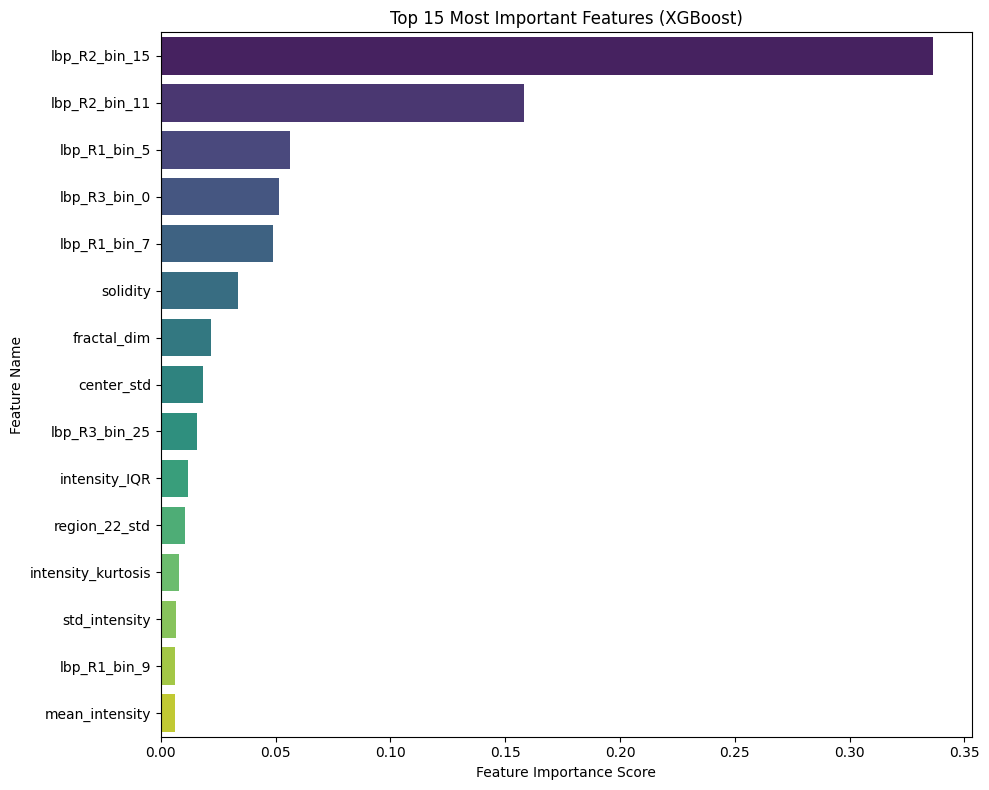


Train Set Performance (Multiclass)
Accuracy: 1.0
Balanced Accuracy: 1.0
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000      2176
           1     1.0000    1.0000    1.0000      2176
           2     1.0000    1.0000    1.0000      2176
           3     1.0000    1.0000    1.0000      2176

    accuracy                         1.0000      8704
   macro avg     1.0000    1.0000    1.0000      8704
weighted avg     1.0000    1.0000    1.0000      8704



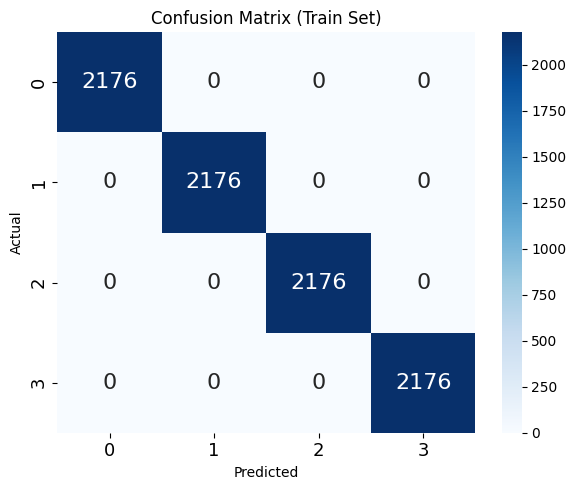


Validation Set Performance (Multiclass)
Accuracy: 0.9134114583333334
Balanced Accuracy: 0.9134114583333334
              precision    recall  f1-score   support

           0     0.8612    0.8724    0.8668       384
           1     0.8582    0.8672    0.8627       384
           2     0.9465    0.9219    0.9340       384
           3     0.9896    0.9922    0.9909       384

    accuracy                         0.9134      1536
   macro avg     0.9139    0.9134    0.9136      1536
weighted avg     0.9139    0.9134    0.9136      1536



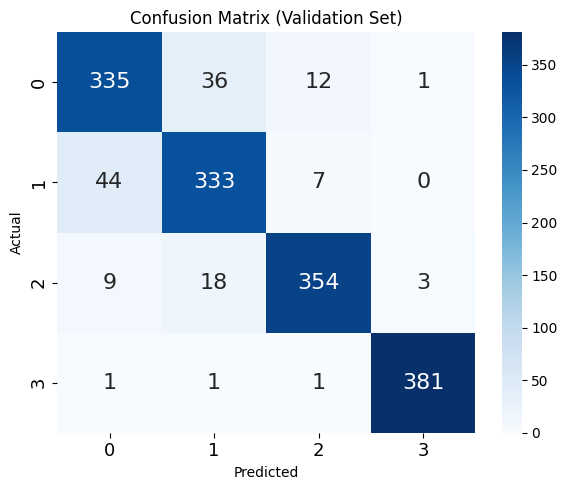


Test Set Performance (Multiclass)
Accuracy: 0.8076622361219703
Balanced Accuracy: 0.6780066382349028
              precision    recall  f1-score   support

           0     0.8370    0.8984    0.8666       640
           1     0.7788    0.7545    0.7664       448
           2     0.7770    0.6425    0.7034       179
           3     0.5000    0.4167    0.4545        12

    accuracy                         0.8077      1279
   macro avg     0.7232    0.6780    0.6977      1279
weighted avg     0.8050    0.8077    0.8048      1279



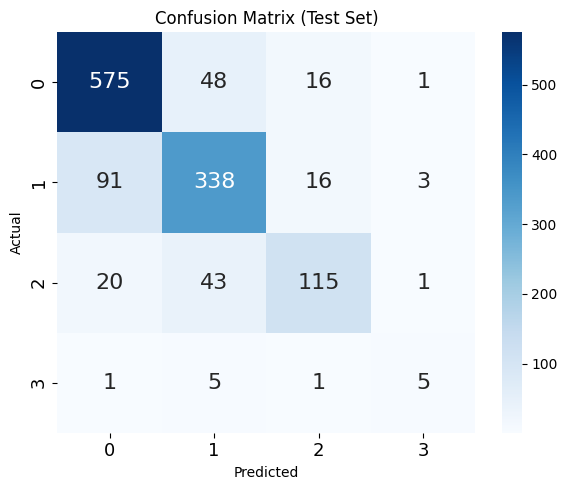

In [ ]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.metrics import (
    accuracy_score, classification_report,
    confusion_matrix, balanced_accuracy_score, roc_curve
)
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product
from xgboost import XGBClassifier

# --- Load Datasets ---
df = pd.read_csv("train_features_scaled.csv")
val_df = pd.read_csv("val_features_scaled.csv")
test_df = pd.read_csv("test_features_scaled.csv")

core_features = df.drop(columns=["label", "label_name"], errors="ignore").columns.tolist()

# --- Extract Features and Labels ---
X_train = df[core_features]
y_train = df["label"]
X_val = val_df[core_features]
y_val = val_df["label"]
X_test = test_df[core_features]
y_test = test_df["label"]


# --- Manual Grid Search using Validation Set ---
param_grid = {
    'max_depth': [3, 5, 7, 9, 11, 12, 13],
    'learning_rate': [0.01, 0.1, 0.2, 0.3, 0.4],
    'n_estimators': [100, 200, 300, 400, 500]
}

best_score = 0
best_params = {}

# Class ratio for scale_pos_weight (Impaired : No Impairment)
num_classes = len(np.unique(y_train))

# print("Hyperparameter tuning on validation set:")
# for max_depth, lr, n_est in product(param_grid['max_depth'],
#                                     param_grid['learning_rate'],
#                                     param_grid['n_estimators']):
#     model = XGBClassifier(
#         objective='multi:softprob',
#         eval_metric='mlogloss',
#         max_depth=max_depth,
#         learning_rate=lr,
#         n_estimators=n_est,
#         random_state=42,
#         verbosity=0
#     )
#     model.fit(X_train, y_train)
#     val_pred = model.predict(X_val)
#     val_score = balanced_accuracy_score(y_val, val_pred)
#     print(f"max_depth={max_depth}, lr={lr}, n_estimators={n_est} → Balanced Acc: {val_score:.4f}")
#     if val_score > best_score:
#         best_score = val_score
#         best_params = {
#             'max_depth': max_depth,
#             'learning_rate': lr,
#             'n_estimators': n_est
#         }
# 
# print("\n Best Params from validation set:")
# print(best_params)
best_params = {
    'max_depth': 11,
    'learning_rate': 0.1,
    'n_estimators': 200
}

# --- Final Model with Early Stopping ---
clf = XGBClassifier(
    objective='multi:softprob',
    eval_metric='merror',
    num_class=num_classes,
    random_state=42,
    early_stopping_rounds=50,
    reg_alpha=1,   
    reg_lambda=1,  
    **best_params
)



class_weights = y_test.value_counts(normalize=True).rdiv(1).to_dict()
sample_weights = y_train.map(class_weights)
clf.fit(
    X_train, y_train,
    sample_weight=sample_weights,
    eval_set=[(X_val, y_val)],
    verbose=False
)

# --- Feature Importance Plot ---
importances = clf.feature_importances_
feature_names = X_train.columns
importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

# Plot Top 15 Features
plt.figure(figsize=(10, 8))
sns.barplot(x="Importance", y="Feature", data=importance_df.head(15), palette="viridis")
plt.title("Top 15 Most Important Features (XGBoost)")
plt.xlabel("Feature Importance Score")
plt.ylabel("Feature Name")
plt.tight_layout()
plt.savefig("xgb_top_15_feature_importance.png")
plt.show()

def evaluate_multiclass(model, X, y, dataset_name="Set"):
    y_pred = model.predict(X)
    print(f"\n{dataset_name} Performance (Multiclass)")
    print("Accuracy:", accuracy_score(y, y_pred))
    print("Balanced Accuracy:", balanced_accuracy_score(y, y_pred))
    print(classification_report(y, y_pred, digits=4))

    cm = confusion_matrix(y, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", annot_kws={"size": 16})
    plt.title(f"Confusion Matrix ({dataset_name})")
    plt.xticks(fontsize=13)
    plt.yticks(fontsize=13)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.savefig(f"confusion_matrix_xgb_4_{dataset_name.lower()}.png")
    plt.show()



# --- Evaluate on Train, Val, and Test ---
evaluate_multiclass(clf, X_train, y_train, "Train Set")
evaluate_multiclass(clf, X_val, y_val, "Validation Set")
evaluate_multiclass(clf, X_test, y_test, "Test Set")


# Binary classification

/home/alof/anaconda3/envs/brainml/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [21:14:23] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



🧪 Train Set Performance (Threshold = 0.5000)
Accuracy: 1.0
Balanced Accuracy: 1.0
               precision    recall  f1-score   support

No Impairment     1.0000    1.0000    1.0000      1849
     Impaired     1.0000    1.0000    1.0000      5549

     accuracy                         1.0000      7398
    macro avg     1.0000    1.0000    1.0000      7398
 weighted avg     1.0000    1.0000    1.0000      7398



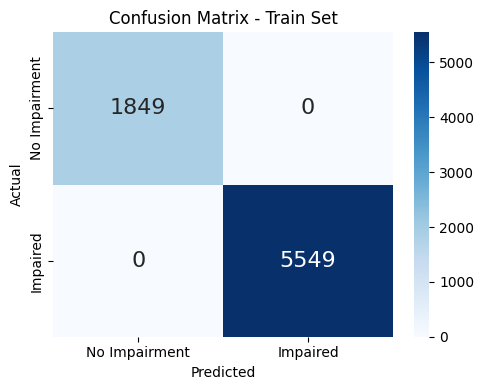


📍 Optimal threshold from validation set: 0.8033

🧪 Validation Set (Optimal Threshold) Performance (Threshold = 0.8033)
Accuracy: 0.9088820826952527
Balanced Accuracy: 0.9239487962815456
               precision    recall  f1-score   support

No Impairment     0.7500    0.9541    0.8398       327
     Impaired     0.9831    0.8938    0.9363       979

     accuracy                         0.9089      1306
    macro avg     0.8666    0.9239    0.8881      1306
 weighted avg     0.9248    0.9089    0.9122      1306



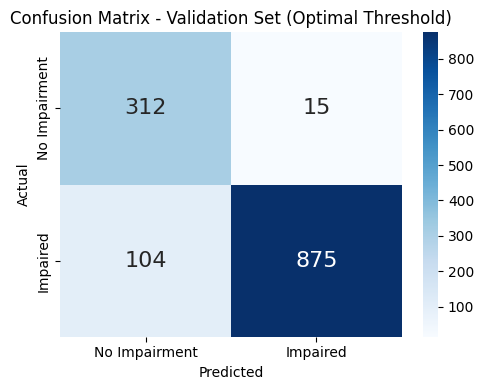

New best threshold (test set): 0.3452

🧪 Test Set Performance (Threshold = 0.3452)
Accuracy: 0.8467552775605942
Balanced Accuracy: 0.8467759683098591
               precision    recall  f1-score   support

No Impairment     0.8663    0.8203    0.8427       640
     Impaired     0.8291    0.8732    0.8506       639

     accuracy                         0.8468      1279
    macro avg     0.8477    0.8468    0.8467      1279
 weighted avg     0.8477    0.8468    0.8467      1279



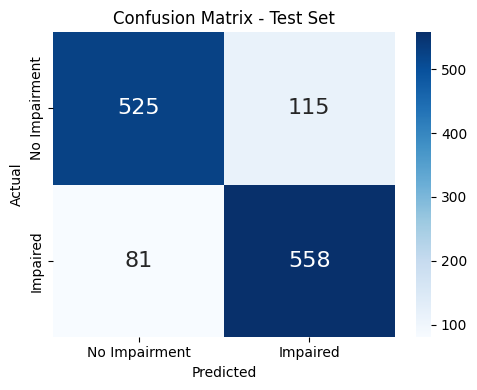

/tmp/ipykernel_12747/3659536255.py:121: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df, palette="viridis")


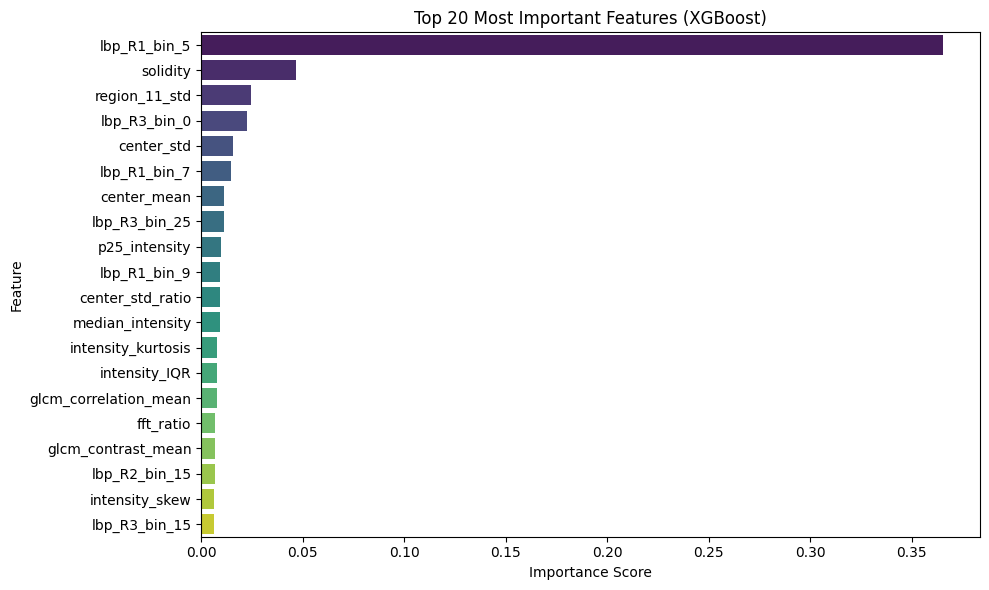

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_score
from sklearn.metrics import (
    accuracy_score, classification_report,
    confusion_matrix, balanced_accuracy_score, roc_curve
)
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier

# --- Load Dataset ---
df = pd.read_csv("train_features.csv")
test_df = pd.read_csv("test_features.csv")

# --- Relabel: 0 = No Impairment, 1 = Any Impairment ---
df['label'] = df['label'].apply(lambda x: 0 if x == 0 else 1)
test_df['label'] = test_df['label'].apply(lambda x: 0 if x == 0 else 1)

# --- Split Train into Train + Validation ---
X_full = df.drop(columns=["label", "label_name"], errors="ignore")
y_full = df["label"]

X_train, X_val, y_train, y_val = train_test_split(
    X_full, y_full, test_size=0.15, stratify=y_full, random_state=42
)

# --- Scale Data ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

X_test = test_df[X_full.columns]
y_test = test_df["label"]
X_test_scaled = scaler.transform(X_test)

# --- Best Params from CV (Precomputed or Use CV Again) ---
best_params = {
    'max_depth': 9,
    'learning_rate': 0.2,
    'n_estimators': 200
}

# --- Compute class imbalance ratio ---
scale_pos_weight = sum(y_train == 0) / sum(y_train == 1)

# --- Train Final Model ---
clf = XGBClassifier(
    objective='binary:logistic',
    use_label_encoder=False,
    eval_metric='logloss',
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    **best_params
)
clf.fit(X_train_scaled, y_train)

# --- Threshold Optimization ---
def find_best_threshold(y_true, y_probs):
    fpr, tpr, thresholds = roc_curve(y_true, y_probs)
    j_scores = tpr - fpr
    best_idx = np.argmax(j_scores)
    return thresholds[best_idx]

# --- Evaluation Utility ---
label_map_binary = {0: "No Impairment", 1: "Impaired"}

def evaluate_binary(X, y, dataset_name="Set", threshold=0.5):
    probs = clf.predict_proba(X)[:, 1]
    y_pred = (probs >= threshold).astype(int)

    print(f"\n🧪 {dataset_name} Performance (Threshold = {threshold:.4f})")
    print("Accuracy:", accuracy_score(y, y_pred))
    print("Balanced Accuracy:", balanced_accuracy_score(y, y_pred))
    print(classification_report(y, y_pred, target_names=label_map_binary.values(), digits=4))

    cm = confusion_matrix(y, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=label_map_binary.values(),
                yticklabels=label_map_binary.values(),
                annot_kws={"size": 16})
    plt.title(f"Confusion Matrix - {dataset_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.savefig(f"confusion_matrix_xgb_binary_{dataset_name.lower().replace(' ', '_')}.png")
    plt.show()

# --- Evaluate ---
evaluate_binary(X_train_scaled, y_train, "Train Set")

val_probs = clf.predict_proba(X_val_scaled)[:, 1]
best_thresh = find_best_threshold(y_val, val_probs)
print(f"\n📍 Optimal threshold from validation set: {best_thresh:.4f}")

evaluate_binary(X_val_scaled, y_val, "Validation Set (Optimal Threshold)", threshold=best_thresh)

# Retune threshold based on test set ROC
def find_best_threshold(y_true, y_probs):
    fpr, tpr, thresholds = roc_curve(y_true, y_probs)
    j_scores = tpr - fpr  # Youden’s J statistic
    best_idx = np.argmax(j_scores)
    return thresholds[best_idx]

best_thresh_test = find_best_threshold(y_test, clf.predict_proba(X_test_scaled)[:, 1])
print(f"New best threshold (test set): {best_thresh_test:.4f}")
evaluate_binary(X_test_scaled, y_test, "Test Set", threshold=best_thresh_test)

# Feature mais importantes
importances = clf.feature_importances_
feature_names = X_full.columns

importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False).head(20)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette="viridis")
plt.title("Top 20 Most Important Features (XGBoost)")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()
